<a href="https://colab.research.google.com/github/adityamukherjee42/Ocular-Disease-Recognition-/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/amd/')

Mounted at /amd/


In [ ]:
!cp /amd/My\ Drive/ODIR-5K.zip /content/

In [ ]:
!unzip ODIR-5K.zip

Streaming output truncated to the last 5000 lines.
  inflating: ODIR-5K/ODIR-5K/Training Images/2374_left-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/264_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4246_left-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3986_left-D&H&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4658_right-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3010_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1869_left-A.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4339_left-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/139_right-D&H&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/746_right-G&D&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3336_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/287_left-O.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1202_left-A&NaN&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1623_left-M.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/14

In [ ]:
#augmentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
batch_size = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [ ]:
import glob
import random

In [ ]:
!mkdir ODIR-5K/ODIR-5K/testing_Images

In [ ]:
all_paths = []
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Validation_Images/*.jpg"):
  all_paths.append(element)

In [ ]:
num_to_select = 1000                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/ODIR-5K/testing_Images/"+p[-1])

In [ ]:
all_paths_testing=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/testing_Images/*.jpg"):
  all_paths_testing.append(element)

In [ ]:
all_paths_training=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Training Images/*.jpg"):
  all_paths_training.append(element)

In [ ]:
all_paths_validation=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Validation_Images/*.jpg"):
  all_paths_validation.append(element)

In [ ]:
batchsize=32

In [ ]:
f= open("ODIR-5K/ODIR-5K/training.txt","w")
for i in all_paths_training:
  f.write(str(i)+"\n")
f= open("ODIR-5K/ODIR-5K/testing.txt","w")
for i in all_paths_testing:
  f.write(str(i)+"\n")
f= open("ODIR-5K/ODIR-5K/validation.txt","w")
for i in all_paths_validation:
  f.write(str(i)+"\n")

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [ ]:
def get_label(name):
  parts = name.split("-")
  label = parts[-1].split(".")
  label = label[0]
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

In [ ]:
class OCCULAR(Dataset):
  def __init__(self, root_dir,file_text, transform=None):
      
      self.root_dir = root_dir
      self.img_list = []
      self.label_list =[]
      with open(file_text) as f:
        lines = f.readlines()
        for i in range(len(lines)):
          self.img_list.append(lines[i].rstrip("\n"))
          self.label_list.append(get_label(lines[i]))
      self.transform = transform

  def __len__(self):
      return len(self.img_list)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_path = self.img_list[idx]
      image = Image.open(img_path).convert('RGB')

      if self.transform:
          image = self.transform(image)
      sample = {'img': image,
                'label': self.label_list[idx][1]}
      return sample


In [ ]:
trainset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/Training Images',
                              file_text='/content/ODIR-5K/ODIR-5K/training.txt',
                              transform= train_transformer)
testset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/testing_Images',
                              file_text='/content/ODIR-5K/ODIR-5K/testing.txt',
                              transform= train_transformer)
validationset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/Validation_Images',
                              file_text='/content/ODIR-5K/ODIR-5K/validation.txt',
                              transform= train_transformer)

In [ ]:
print(trainset.__len__())
print(validationset.__len__())
print(testset.__len__())

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(validationset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

4614
829
1000


In [ ]:
import numpy
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


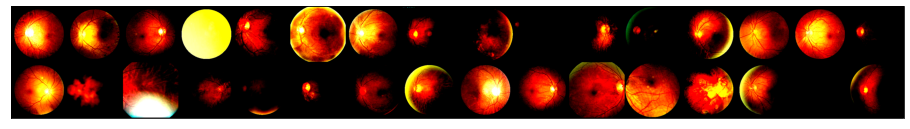

In [ ]:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images['img'],nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [ ]:
class EYE(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5,5),# output: 50 x 50 x 64
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(5, 5), # output: 10 x 10 x 128
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5, 5) #output 2*2*256
            )
        self.linear=nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024,64),
            nn.ReLU(),
            nn.Linear(64,8),
        )
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
      x = self.network(x)
      x=self.linear(x)
      x = self.softmax(x)
      return x
          
                

In [ ]:
device = torch.device("cuda")

In [ ]:
model = EYE()

# push the model to GPU
model = model.to(device)


In [ ]:
cross_entropy  = nn.NLLLoss() 
epochs =100

In [ ]:
from torch.optim import Adam

# define the optimizer
optimizer =Adam(model.parameters(), lr=0.0001)   

In [ ]:
def train():
  
  model.train()
  lambda1, lambda2 = 0.5, 0.01
  total_loss, total_accuracy = 0, 0
  total_preds=[]
  for step,batch in enumerate(train_loader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
    img, labels = batch['img'].cuda(),batch['label'].cuda()
    model.zero_grad()        
    preds = model(img)
    loss = cross_entropy(preds, labels) 
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)
  avg_loss = total_loss / len(train_loader)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
def evaluate():
  lambda1, lambda2 = 0.5, 0.01
  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step,batch in enumerate(val_loader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_loader)))
    img, labels = batch['img'].cuda(),batch['label'].cuda()
    with torch.no_grad():
      preds = model(img)
      loss = cross_entropy(preds, labels) 
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_loader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.583
Validation Loss: 0.600

 Epoch 2 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.576
Validation Loss: 0.577

 Epoch 3 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.576
Validation Loss: 0.597

 Epoch 4 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.576

 Epoch 5 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.567
Validation Loss: 0.566

 Epoch 6 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.564
Validation Loss: 0.560

 Epoch 7 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.560
Validation Loss: 0.563

 Epoch 8 / 100
  Batch    50  of    145.
  Batch   100  of    145.

Evaluating...

Training Loss: 0.553

KeyboardInterrupt: ignored